In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
from utils.ci import bootstrap_ci
from utils.visulize import plot_grouped_bar_with_ci
from utils.grouping import get_group_labels

In [2]:
# load data
df = pd.read_csv('./summary_results.csv')
dataset_name = "PN"  # Change to 'CF', 'CON', etc., for other comparisons
df = df[df['dataset'] == dataset_name].copy()

# ensure df has 240 rows excluding the title row
assert df.shape[0] == 240, f"Expected 240 rows, but got {df.shape[0]} rows."

In [3]:
print(df.columns)
metric_names = ['accuracy', 'f1_score', 'precision', 'recall', 'roc_auc']
models = df['model'].unique()

Index(['dataset', 'seed', 'model', 'accuracy', 'f1_score', 'precision',
       'recall', 'roc_auc'],
      dtype='object')



===== ACCURACY =====
Kruskal-Wallis: H = 131.170, p = 0.0000

Post-hoc Dunn’s test (Holm-corrected):
                      logistic      lstm  lstm-features   lstmfcn  \
logistic          1.000000e+00  0.000359       0.000372  0.000610   
lstm              3.591882e-04  1.000000       1.000000  1.000000   
lstm-features     3.721276e-04  1.000000       1.000000  1.000000   
lstmfcn           6.097886e-04  1.000000       1.000000  1.000000   
lstmfcn-features  3.721276e-04  1.000000       1.000000  1.000000   
randomforest      1.269672e-01  0.987988       0.987988  1.000000   
svm               3.220567e-19  0.000009       0.000009  0.000004   
vivit             1.000000e+00  0.000029       0.000030  0.000055   

                  lstmfcn-features  randomforest           svm         vivit  
logistic                  0.000372  1.269672e-01  3.220567e-19  1.000000e+00  
lstm                      1.000000  9.879885e-01  8.997306e-06  2.859137e-05  
lstm-features             1.000000  9.8

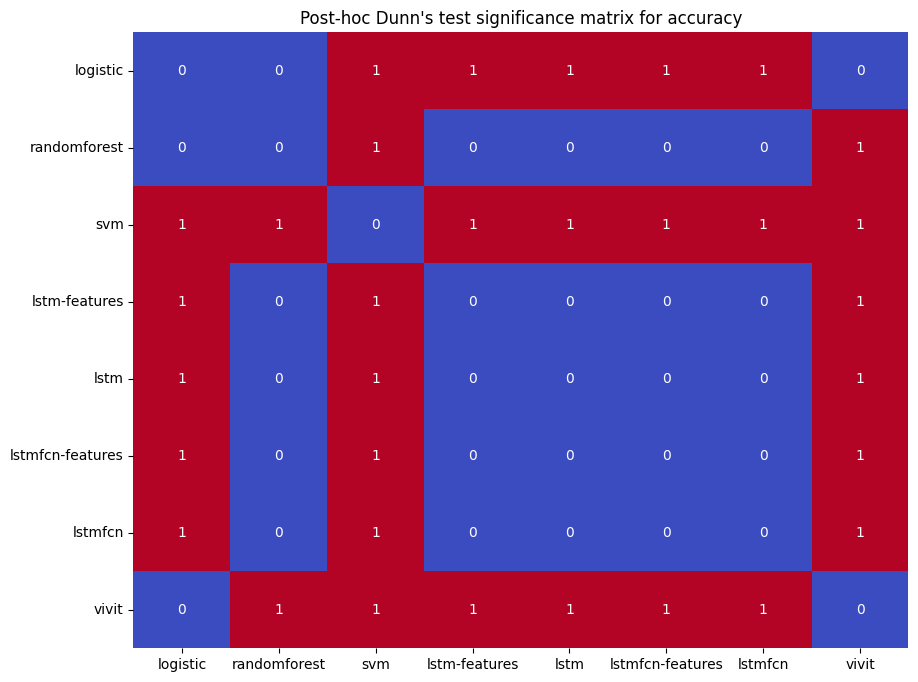

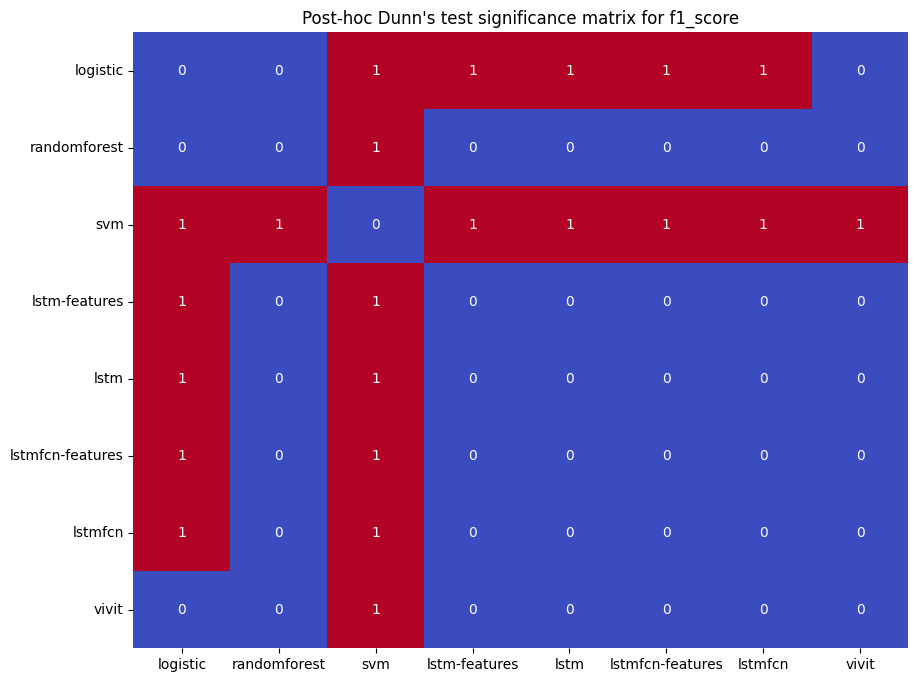

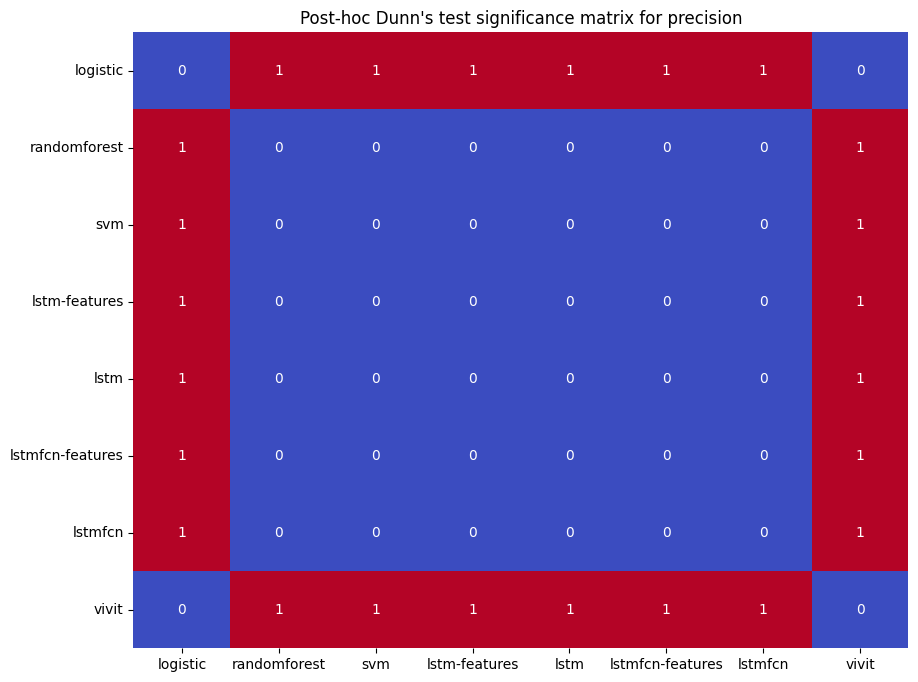

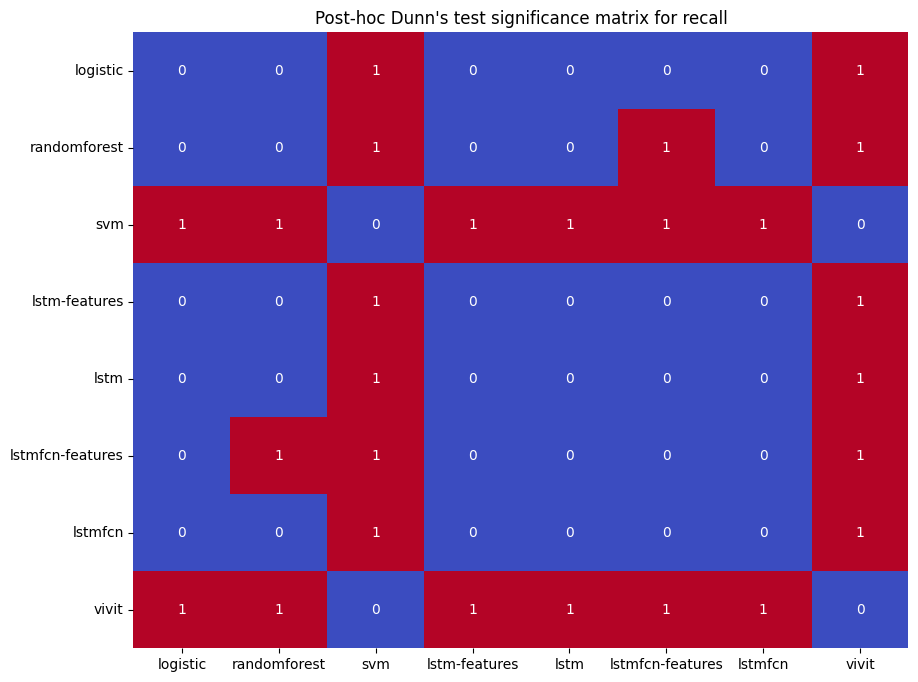

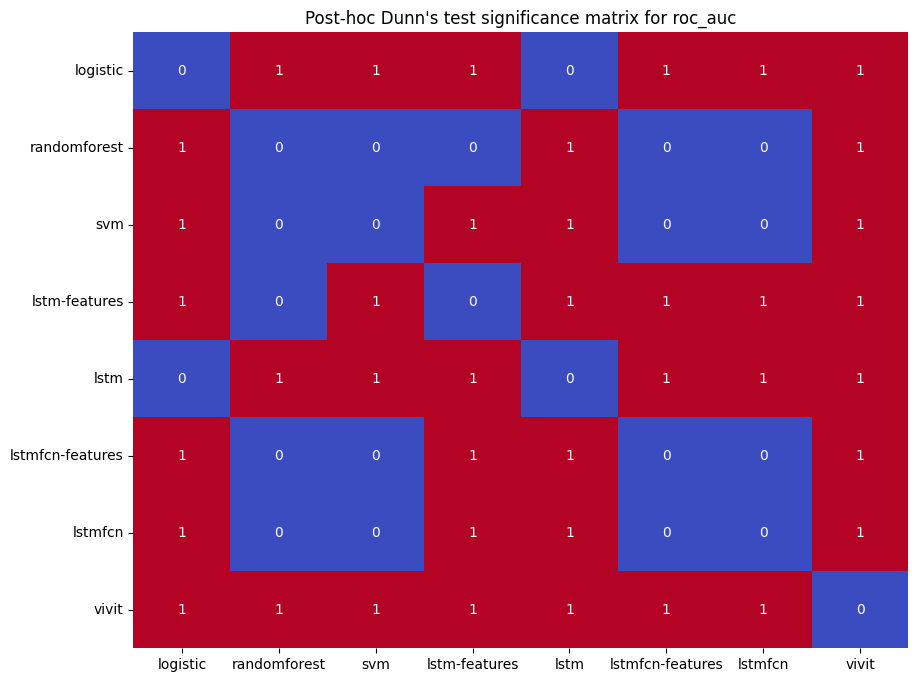

In [4]:
# Run analysis per metric
posthoc_results = {}
for metric in metric_names:
    print(f"\n===== {metric.upper()} =====")
    data_by_model = [df[df['model'] == m][metric] for m in models]

    # Kruskal-Wallis test
    H, p = kruskal(*data_by_model)
    print(f"Kruskal-Wallis: H = {H:.3f}, p = {p:.4f}")
    
    # Post-hoc test if significant
    if p < 0.05:
        posthoc = sp.posthoc_dunn(df, val_col=metric, group_col='model', p_adjust='holm')
        posthoc_results[metric] = posthoc
        print("\nPost-hoc Dunn’s test (Holm-corrected):")
        print(posthoc)

        sig_plot = posthoc.apply(lambda x: x < 0.05).astype(int)
        # Plotting the significance matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(sig_plot.loc[models, models], annot=True, cmap='coolwarm', cbar=False)
        plt.title(f"Post-hoc Dunn's test significance matrix for {metric}")
    else:
        print("No statistically significant difference among models.")

In [5]:
group_labels_per_metric = get_group_labels(posthoc_results, alpha=0.05)
print(group_labels_per_metric)


{'accuracy': {'lstm': 'A', 'lstm-features': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'A', 'randomforest': 'A', 'logistic': 'B', 'vivit': 'C', 'svm': 'D'}, 'f1_score': {'lstm': 'A', 'lstm-features': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'A', 'randomforest': 'A', 'vivit': 'A', 'logistic': 'B', 'svm': 'C'}, 'precision': {'lstm': 'A', 'lstm-features': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'A', 'randomforest': 'A', 'svm': 'A', 'logistic': 'B', 'vivit': 'B'}, 'recall': {'logistic': 'A', 'lstm': 'A', 'lstm-features': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'A', 'randomforest': 'B', 'svm': 'C', 'vivit': 'C'}, 'roc_auc': {'lstmfcn': 'A', 'lstmfcn-features': 'A', 'randomforest': 'A', 'svm': 'A', 'logistic': 'B', 'lstm': 'B', 'lstm-features': 'C', 'vivit': 'D'}}


Model: logistic, Metric: accuracy, Mean: 0.7540476190476189, CI: [0.7519047619047619, 0.7564285714285713]
Model: randomforest, Metric: accuracy, Mean: 0.7635714285714286, CI: [0.7580952380952382, 0.7688154761904763]
Model: svm, Metric: accuracy, Mean: 0.8009523809523811, CI: [0.7985714285714286, 0.8033333333333333]
Model: lstm, Metric: accuracy, Mean: 0.7716666666666668, CI: [0.7657142857142856, 0.7776190476190478]
Model: lstm-features, Metric: accuracy, Mean: 0.7707142857142858, CI: [0.7664285714285715, 0.7745238095238095]
Model: lstmfcn, Metric: accuracy, Mean: 0.7707142857142857, CI: [0.7680952380952382, 0.7733333333333334]
Model: lstmfcn-features, Metric: accuracy, Mean: 0.7714285714285712, CI: [0.7685714285714284, 0.7747619047619048]
Model: vivit, Metric: accuracy, Mean: 0.7407142857142859, CI: [0.7321428571428573, 0.7492916666666667]
Model: logistic, Metric: f1_score, Mean: 0.7552175874992672, CI: [0.7527679718841416, 0.7579334758446911]
Model: randomforest, Metric: f1_score, Mea

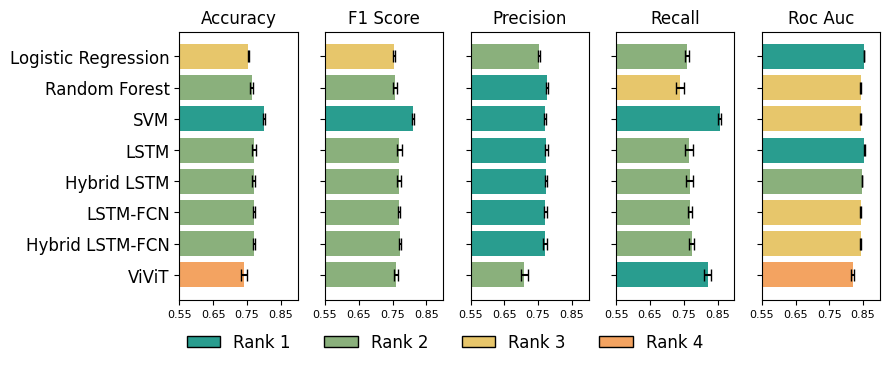

In [6]:
plot_grouped_bar_with_ci(models, df, group_labels_per_metric, 'Pinot Noir')

In [7]:
# change the col and row names to these model names
model_names = {
    'logistic': 'Logistic Regression',
    'randomforest': 'Random Forest',
    'svm': 'SVM',
    'lstm-features': 'Hybrid LSTM',
    'lstm': 'LSTM',
    'lstmfcn-features': 'Hybrid LSTM-FCN',
    'lstmfcn': 'LSTM-FCN',
    'vivit': 'ViVit',
}
# set the ordering for the col and row names
model_order = [
    'logistic',
    'randomforest',
    'svm',
    'lstm',
    'lstm-features',
    'lstmfcn',
    'lstmfcn-features',
    'vivit',
]

# for all values in posthoc_results, only remain 3 digits
# e.g. 0.123456 -> 0.123; 1.0 -> 1.00; 0.01123121e-05 -> 0.01e-05； 1 -> 1.00
# store each metric's posthoc result to a csv file
def fmt_three_digits(x):
    # Leave non-numerics (e.g., "ns", "-") alone
    if isinstance(x, (np.integer, int, np.floating, float)):
        s = f"{float(x):.3g}"  # 3 significant digits; uses sci-notation when appropriate
        # If not scientific and no decimal point, pad to .00 (e.g., 1 -> 1.00)
        if 'e' not in s and '.' not in s:
            s = s + '.00'
        return s
    return x


for metric, df in posthoc_results.items():
    # 1) format numbers
    df = df.applymap(fmt_three_digits)

    # 2) rename rows/cols to pretty names
    df = df.rename(index=model_names, columns=model_names)

    # 3) order rows/cols safely (keep only those present)
    desired_idx = [model_names[m] for m in model_order if model_names.get(m) in df.index]
    desired_cols = [model_names[m] for m in model_order if model_names.get(m) in df.columns]
    df = df.loc[desired_idx, desired_cols]

    # 4) save
    df.to_csv(f'./tables/posthoc_dunn_{dataset_name}_{metric}.csv')

C:\Users\Mud\AppData\Local\Temp\ipykernel_60580\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_60580\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_60580\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_60580\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_60580\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
